In [62]:
import numpy as np
import pandas as pd
import os
import sys
from scipy.stats import skew 
import librosa
import time as time
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')
import utility
from sktime.utils.data_io import load_from_tsfile_to_dataframe,load_from_arff_to_dataframe
from sktime.datasets import load_UCR_UEA_dataset

def get_entropy(timeseries):
    timeseries_nz = timeseries[timeseries != 0]
    return - np.sum(((timeseries_nz**2)*np.log(timeseries_nz**2)))
    
def get_energy(timeseries):  
    N = len(timeseries)
    return np.sum(np.abs(timeseries) ** 2) / N
    
def get_features(data, n_mfcc = 30):
    if isinstance(data, pd.Series):
        data = data.to_numpy()
    sr = 4000
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), get_energy(data), get_entropy(data)))
  
    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
    
    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))

def get_new_X(X):
    df = X.copy()
    
    df= df['dim_0'].apply(lambda x: get_features(x))
    #for i, row in X.iterrows():
    #    new_row = get_features(row.values[0].to_numpy())
    #    df = df.append(new_row,ignore_index=True)
    return df

def write_to_ts(filepath, X, y):
    
    w = open(filepath, 'w+')
    
    w.write('@problemName LungSoundsMiniROCKET \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write(f'@seriesLength {str(len(X.columns))} \n')
    w.write('@classLabel true no_crackle crackle\n')
    w.write('@data \n')
    for (idx, row) in X.iterrows():
        new_row = str((list(row)))[1:-1].replace(' ', '') + ':' + y[idx] + '\n'
        w.write(new_row)
        
def convert_arff_to_ts(filepath, filename):
    X, y = load_from_arff_to_dataframe(filepath + '/' + filename)
    new_filename = filename[:-4] + 'ts'
    print(new_filename)
    dataset = filename.split('_')[0]
    print(dataset)
    
    labels = np.unique(y).astype(str)
    label_str = ''
    for label in labels:
        label_str = label_str + label + ' '
    print(label_str)
    w = open(filepath + '/' + new_filename, 'w+')
    
    w.write(f'@problemName {dataset} \n')
    w.write('@timeStamps false \n')
    w.write('@univariate true \n')
    w.write(f'@classLabel true {label_str} \n')
    w.write('@data \n')
    for (idx, row) in X.iterrows():
        new_row = (list(row)[0]).tolist()
        new_row = str(new_row)[1:-1].replace(' ', '') + ':' + y[idx] + '\n'
        w.write(new_row)


In [23]:
start = time.time()
X, y = load_from_tsfile_to_dataframe(module_path + '/data/ts_files/crackleNoCrackle_FULL.ts')
print('Time to fetch X y: ', time.time() - start)

Time to fetch X y:  98.97856712341309


In [17]:

name_UCR = 'BinaryHeartbeat'

# Code below is to fix the issue that this dataset does not have .ts files yet 
filepath = f'/home/andrine/anaconda3/lib/python3.7/site-packages/sktime/datasets/data/{name_UCR}'
filename  = f'{name_UCR}_TEST.arff'
convert_arff_to_ts(filepath, filename)
filename  = f'{name_UCR}_TRAIN.arff'
convert_arff_to_ts(filepath, filename)



BinaryHeartbeat_TEST.ts
BinaryHeartbeat
Abnormal Normal 
BinaryHeartbeat_TRAIN.ts
BinaryHeartbeat
Abnormal Normal 


In [16]:
name_UCR = 'BinaryHeartbeat'

# Code below is to fix the issue that this dataset does not have .ts files yet 
filepath = f'/home/andrine/anaconda3/lib/python3.7/site-packages/sktime/datasets/data/{name_UCR}/{name_UCR}'

X_train, y_train = load_from_tsfile_to_dataframe(filepath + '_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(filepath + '_TEST.ts')
X = pd.concat([X_train, X_test])
y = np.concatenate([y_train, y_test])

In [ ]:
start = time.time()
X, y = load_from_tsfile_to_dataframe(module_path + '/data/ts_files/crackleNoCrackle_FULL.ts')
print('Time to fetch X y: ', time.time() - start)

In [63]:
start = time.time()

new_X = get_new_X(X)

print('Time to extract features from pre project: ', str(time.time() - start))

/home/andrine/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1824
  n_fft, y.shape[-1]
/home/andrine/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1944
  n_fft, y.shape[-1]
/home/andrine/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1600
  n_fft, y.shape[-1]


Time to extract features from pre project:  258.0599992275238


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

kwargs = dict(test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(new_X, y, **kwargs)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

0.813768115942029

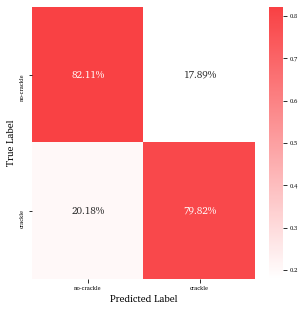

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

clf =KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1).fit(X_train,y_train)

pred = clf.predict(X_test)
#cf_matrix = confusion_matrix(y_test, pred)
utility.plot_cm(y_test, pred, module_path = module_path)

#plot_confusion_matrix(clf, X_test, y_test)
accuracy_score(y_test, pred )

In [21]:
type(y_train)

numpy.ndarray

In [29]:
write_to_ts(module_path + '/features/extracted_features_ts_files/binaryheart_preproject_TRAIN.ts', X_train_norm, y_train)
write_to_ts(module_path + '/features/extracted_features_ts_files/binaryheart_preproject_TEST.ts', X_test_norm, y_test)